In [ ]:
## Stage 3b — Graph Exploration & Outlier Detection

"""
Stage 3b — Graph Exploration & Outlier Detection

Connects to the RunningAnalytics Neo4j graph and queries all run data for exploratory analysis.
Visualizes pace, cadence, distance, and elevation distributions to reveal patterns and detect anomalies.
Highlights potential outliers (e.g., pace <3 or >8 min/km, distance >25 km) and identifies run types such
as long runs, recovery sessions, and inconsistent recordings.

The goal is to validate and enrich the dataset prior to machine learning. 
The cleaned and annotated output from this stage serves as input to Stage 4 (Feature Engineering & ML Prep).
"""


In [2]:
# --- 2. Load all runs into a DataFrame ---
with driver.session() as session:
    query = """
    MATCH (r:Run)-[:ON_DATE]->(d:Date)
    RETURN 
        r.run_id AS run_id,
        r.total_distance_km AS km,
        r.avg_pace AS pace,
        r.avg_speed AS speed,
        r.avg_cadence AS cadence,
        r.elevation_gain AS elev,
        r.duration_min AS duration,
        d.date AS date
    ORDER BY d.date
    """
    df = pd.DataFrame(session.run(query).data())

driver.close()

print(f"✅ Loaded {len(df):,} runs from Neo4j")
df.head()




✅ Loaded 697 runs from Neo4j


,run_id,km,pace,speed,cadence,elev,duration,date
0,5133288526,8.94445,4.474358,3.748953,86.536471,24.6,37.516667,2020-11-24
1,5133288498,1.88915,4.771901,3.581329,86.300000,11.0,6.800000,2020-11-29
2,5133288545,5.02023,3.951897,4.265980,88.983607,17.4,18.066667,2020-11-29
3,5133288575,2.29593,5.506562,3.282670,81.752294,3.4,8.700000,2020-11-29
4,5133288725,9.32303,4.393862,3.828436,87.528678,16.6,37.083333,2020-12-05


In [1]:
# --- 1. Imports and Setup ---
from neo4j import GraphDatabase
from dotenv import load_dotenv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

load_dotenv()

driver = GraphDatabase.driver(
    os.getenv("NEO4J_URI"),
    auth=(os.getenv("NEO4J_USER"), os.getenv("NEO4J_PASS"))
)

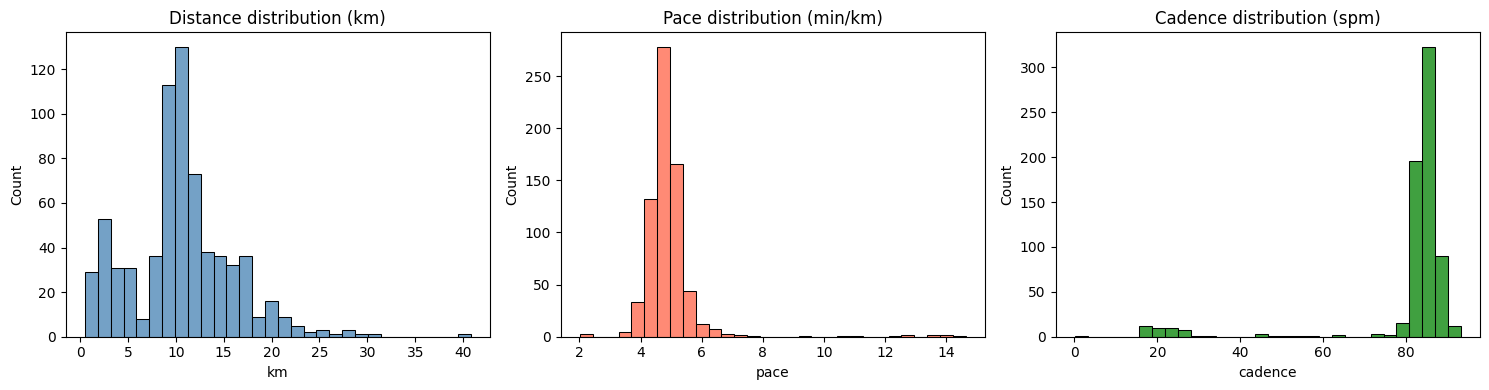

In [3]:
# --- 3. Basic distributions ---
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
sns.histplot(df["km"], bins=30, ax=axes[0], color="steelblue")
axes[0].set_title("Distance distribution (km)")
sns.histplot(df["pace"], bins=30, ax=axes[1], color="tomato")
axes[1].set_title("Pace distribution (min/km)")
sns.histplot(df["cadence"], bins=30, ax=axes[2], color="green")
axes[2].set_title("Cadence distribution (spm)")
plt.tight_layout()




In [4]:
# --- 4. Detect anomalies ---
# Define thresholds for "normal" runs
pace_outliers = df[(df["pace"] > 8) | (df["pace"] < 3)]
distance_outliers = df[df["km"] > 25]
print(f"Pace outliers: {len(pace_outliers)}  |  Long runs (>25 km): {len(distance_outliers)}")






Pace outliers: 14  |  Long runs (>25 km): 10


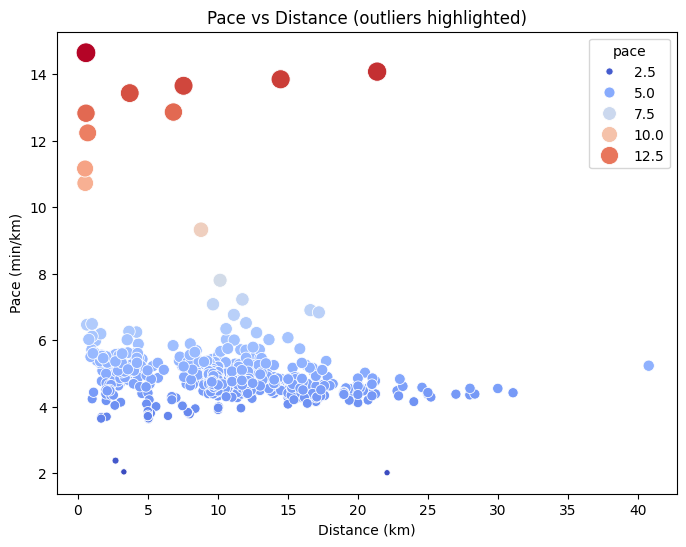

In [5]:
# --- 5. Visualize pace vs. distance ---
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x="km", y="pace", hue="pace",
                palette="coolwarm", size="pace", sizes=(20,200))
plt.title("Pace vs Distance (outliers highlighted)")
plt.xlabel("Distance (km)")
plt.ylabel("Pace (min/km)")
plt.show()

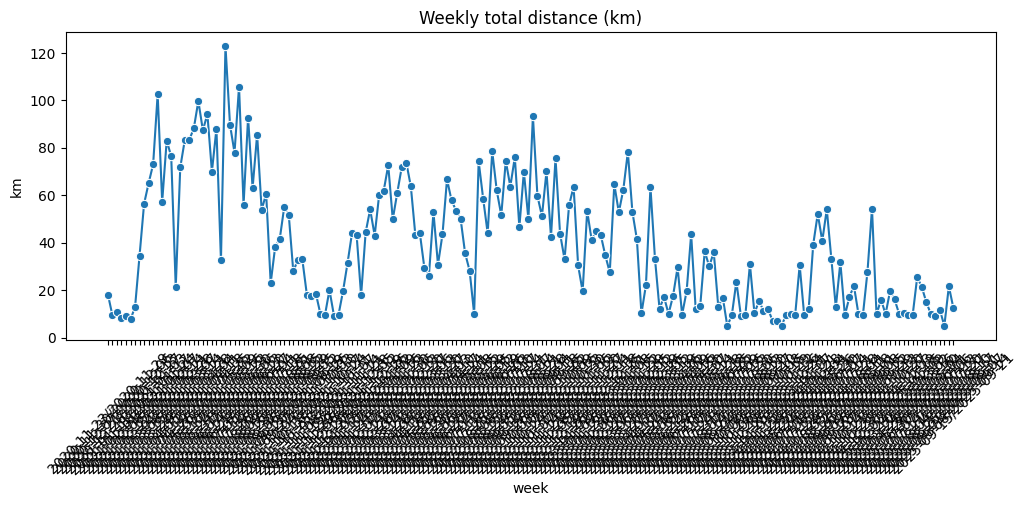

In [7]:
# --- 6. Summary of weekly averages ---
# Convert Neo4j date objects → ISO strings → pandas datetime
df["date"] = df["date"].apply(lambda d: str(d))  # or d.to_native() if supported
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df["week"] = df["date"].dt.to_period("W").astype(str)

weekly = (
    df.groupby("week")
      .agg({"km":"sum", "pace":"mean", "cadence":"mean"})
      .reset_index()
      .sort_values("week")
)

plt.figure(figsize=(12,4))
sns.lineplot(data=weekly, x="week", y="km", marker="o")
plt.title("Weekly total distance (km)")
plt.xticks(rotation=45)
plt.show()

In [8]:
# --- 7. Export results for next phase ---
df.to_csv("../data/strava/processed/neo4j_exploration.csv", index=False)
print("✅ Saved exploration dataset for Stage 4 (ML prep).")

✅ Saved exploration dataset for Stage 4 (ML prep).
